# Custom SpaCy TextCategorizer for Financial Sentiment

In this notebook, we train a custom sentiment analysis model using SpaCy’s built-in `TextCategorizer` pipeline component.

We’ll use our cleaned `train.csv` and `val.csv` datasets to train and evaluate this rule-free model.

-   Fine-tuned on your labeled financial data
-   Outputs one of: **positive**, **neutral**, **negative**


In [2]:
import sys

sys.path.append("../scripts")

import random

import pandas as pd
import spacy
from metrics import per_source_metrics
from plot_utils import plot_confusion_matrix
from sklearn.metrics import classification_report
from spacy.training.example import Example
from spacy.util import minibatch
from tqdm import tqdm

## Load Training & Validation Data


In [3]:
train_df = (
    pd.read_csv("../data/processed/train.csv").dropna(subset=["sentence"]).astype(str)
)
val_df = pd.read_csv("../data/processed/val.csv").astype(str)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Train label breakdown:\n", train_df["label"].value_counts(), "\n")

Train size: 16022
Validation size: 1781
Train label breakdown:
 label
neutral     9573
positive    3989
negative    2460
Name: count, dtype: int64 



## Prepare Data for Training

We structure the examples as required by spaCy's training API.


In [4]:
def to_spacy_format(row):
    cats = {"positive": 0.0, "neutral": 0.0, "negative": 0.0}
    cats[row["label"]] = 1.0
    return (row["sentence"], {"cats": cats})


train_data = [to_spacy_format(row) for _, row in train_df.iterrows()]
print(f"Loaded {len(train_data)} training examples.")

Loaded 16022 training examples.


## Initialize SpaCy Model and TextCategorizer


In [ ]:
nlp = spacy.blank("en")

textcat = nlp.add_pipe("textcat", last=True)

textcat.add_label("positive")
textcat.add_label("neutral")
textcat.add_label("negative")

1

## Training Loop

We use spaCy’s built-in training loop with minibatching.


In [5]:
n_iter = 10
batch_size = 16  # or 8, 32 depending on your hardware
optimizer = nlp.begin_training()

for epoch in tqdm(range(n_iter)):
    random.shuffle(train_data)
    losses = {}

    # Batch the examples
    batches = minibatch(train_data, size=batch_size)

    for batch in batches:
        texts, annotations = zip(*batch)
        examples = [
            Example.from_dict(nlp.make_doc(text), ann)
            for text, ann in zip(texts, annotations)
        ]
        nlp.update(examples, sgd=optimizer, drop=0.3, losses=losses)

    print(f"Epoch {epoch+1}/{n_iter} | Loss: {losses['textcat']:.4f}")

 10%|█         | 1/10 [00:29<04:23, 29.29s/it]

Epoch 1/10 | Loss: 154.3297


 20%|██        | 2/10 [01:02<04:14, 31.85s/it]

Epoch 2/10 | Loss: 117.3176


 30%|███       | 3/10 [01:40<04:00, 34.39s/it]

Epoch 3/10 | Loss: 97.6208


 40%|████      | 4/10 [02:21<03:43, 37.21s/it]

Epoch 4/10 | Loss: 85.3419


 50%|█████     | 5/10 [03:01<03:11, 38.20s/it]

Epoch 5/10 | Loss: 76.2526


 60%|██████    | 6/10 [03:43<02:37, 39.25s/it]

Epoch 6/10 | Loss: 67.9376


 70%|███████   | 7/10 [04:24<02:00, 40.00s/it]

Epoch 7/10 | Loss: 60.5644


 80%|████████  | 8/10 [05:06<01:21, 40.63s/it]

Epoch 8/10 | Loss: 55.6493


 90%|█████████ | 9/10 [05:49<00:41, 41.37s/it]

Epoch 9/10 | Loss: 51.4882


100%|██████████| 10/10 [06:32<00:00, 39.24s/it]

Epoch 10/10 | Loss: 45.9416


## Save Trained Model


In [ ]:
nlp.to_disk("../models/spacy/spacy_custom")

## Run Inference on Validation Set


In [7]:
nlp = spacy.load("../models/spacy/spacy_custom")

preds = []
for text in val_df["sentence"]:
    doc = nlp(text)
    pred_label = max(doc.cats, key=doc.cats.get)
    preds.append(pred_label)

## Evaluation

### Classification Report


In [8]:
y_true = val_df["label"]
y_pred = preds

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    negative       0.72      0.62      0.67       274
     neutral       0.83      0.88      0.85      1064
    positive       0.71      0.67      0.69       443

    accuracy                           0.79      1781
   macro avg       0.75      0.72      0.74      1781
weighted avg       0.78      0.79      0.78      1781



### Confusion Matrix


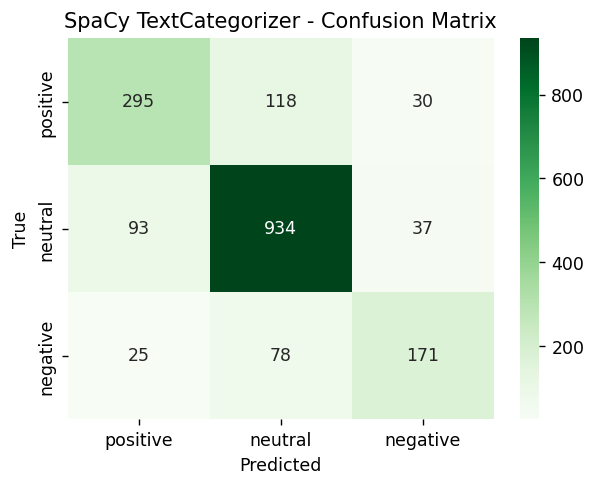

In [9]:
plot_confusion_matrix(
    y_true,
    y_pred,
    labels=["positive", "neutral", "negative"],
    title="SpaCy TextCategorizer - Confusion Matrix",
    cmap="Greens",
)

### Per-Source Metrics


In [10]:
spacy_custom_results = per_source_metrics(y_true, y_pred, val_df["source"])
print("SpaCy TextCategorizer Per-Source Performance:\n")
for source, acc, f1 in spacy_custom_results:
    print(f"{source}: Accuracy={acc:.3f}, Macro-F1={f1:.3f}")

SpaCy TextCategorizer Per-Source Performance:

FPB: Accuracy=0.749, Macro-F1=0.701
Twitter: Accuracy=0.818, Macro-F1=0.759
FiQA: Accuracy=0.602, Macro-F1=0.526


## Save Predictions

We'll save the predictions and metrics for later comparison.


In [11]:
pd.DataFrame(
    classification_report(y_true, y_pred, output_dict=True)
).transpose().to_csv("../models/spacy/spacy-custom-preds.csv")

with open("../models/spacy/spacy-custom-preds.txt", "w") as f:
    for item in preds:
        f.write(item + "\n")

## Summary

This approach trained a **custom SpaCy sentiment classifier** from scratch on labeled financial text.

-   Better suited than rule-based heuristics
-   Fully reproducible on your domain data
-   Still fast and easy to deploy

Next: Let’s evaluate **Azure OpenAI o4-mini** in **[5_o4mini_inference.ipynb](5_o4mini_inference.ipynb)**.
